In [1]:
! pip -q install --no-dependencies equinox jaxtyping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 3.8 MB/s eta 0:00:00


In [2]:
! pip -q install optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 9.9 MB/s eta 0:00:00


In [3]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 170 (delta 93), reused 124 (delta 50), pack-reused 0
Receiving objects: 100% (170/170), 30.32 KiB | 3.79 MiB/s, done.
Resolving deltas: 100% (93/93), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
import jax.numpy as jnp
from jax import config, random, jit, vmap, grad

import equinox as eqx
import optax

from architectures import ChebNO
from datasets import generate_dataset
from misc import equations

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [5]:
def batch_generator(train_data, key, chunk_size):
    train_features, train_targets = train_data
    n = random.permutation(key, jnp.arange(train_features.shape[0], dtype=int))
    train_features, train_targets = train_features[n], train_targets[n]
    chunks = [*range(0, train_features.shape[0] + 1, chunk_size)]
    if chunks[-1] < train_features.shape[0]:
        chunks.append(train_features.shape[0])
    for i, j in zip(chunks[:-1], chunks[1:]):
        yield train_features[i:j], train_targets[i:j]

# Generate dataset

Solve ODE

In [6]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "RK4"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 1
N_intervals = 2
N_SDC = 20
N_samples = 1000

dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)

Check residuals

In [7]:
# computing residual for the last SDC iteration
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print("shape of computed residual", R.shape)
print(jnp.mean(R))

shape of computed residual (1000, 2)
2.345958413065942e-13


Prepare features and targers.

In [8]:
dataset.shape

(1000, 2, 20, 3, 40)

In [9]:
features0 = dataset[:, :, :1, :, :]
targets0 = dataset[:, :, -1, :, :]

feature0_train = features0[:800, :, :, :, :].reshape(800*N_intervals, features0.shape[2]*features0.shape[3], -1)
targets0_train = targets0[:800, :, :, :].reshape(800*N_intervals, targets0.shape[2], -1)

feature0_test = features0[800:, :, :, :, :].reshape(200*N_intervals, features0.shape[2]*features0.shape[3], -1)
targets0_test = targets0[800:, :, :, :].reshape(200*N_intervals, targets0.shape[2], -1)

In [10]:
feature0_train.shape, targets0_train.shape

((1600, 3, 40), (1600, 3, 40))

In [11]:
feature0_test.shape, targets0_test.shape

((400, 3, 40), (400, 3, 40))

In [12]:
features2 = dataset[:, :, :3, :, :]
targets2 = dataset[:, :, -1, :, :]

feature2_train = features2[:800, :, :, :, :].reshape(800*N_intervals, features2.shape[2]*features2.shape[3], -1)
targets2_train = targets2[:800, :, :, :].reshape(800*N_intervals, targets2.shape[2], -1)

feature2_test = features2[800:, :, :, :, :].reshape(200*N_intervals, features2.shape[2]*features2.shape[3], -1)
targets2_test = targets2[800:, :, :, :].reshape(200*N_intervals, targets2.shape[2], -1)

In [13]:
feature2_train.shape, targets2_train.shape

((1600, 9, 40), (1600, 3, 40))

In [14]:
feature2_test.shape, targets2_test.shape

((400, 9, 40), (400, 3, 40))

# Create and train a model

## Features = initial conditions

### Without truncation

In [15]:
key = random.PRNGKey(23)

N_features = [feature0_train.shape[1], 64, targets0_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = feature0_train.shape[2]
model0 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [16]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature0_train.shape[0] / N_batch) * N_epoch_decay, 0.75)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model0, eqx.is_array))

In [17]:
ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

In [18]:
%timeit ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

21.2 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
22 * 1e-3 * (feature0_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [20]:
%timeit ChebNO.compute_loss(model0, feature0_train, targets0_train);

205 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature0_train, targets0_train], key, N_batch)
    for feature, target in ds:
        loss, model0, opt_state = ChebNO.make_step(model0, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model0, feature0_train, targets0_train).item())
    e_test.append(ChebNO.compute_loss(model0, feature0_test, targets0_test).item())

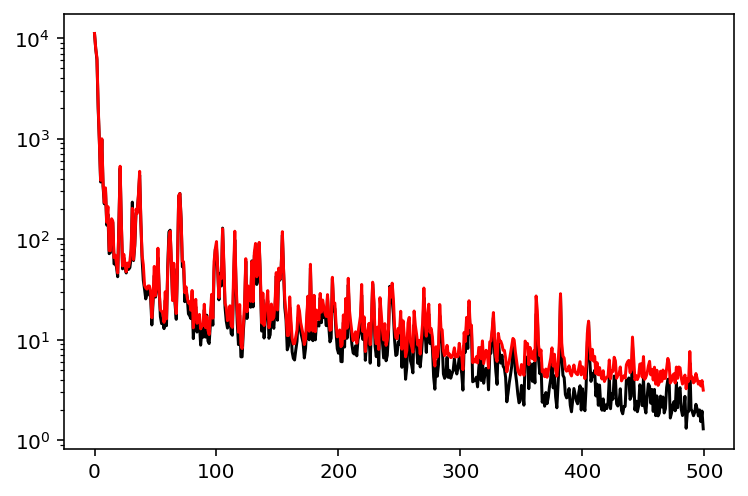

In [22]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

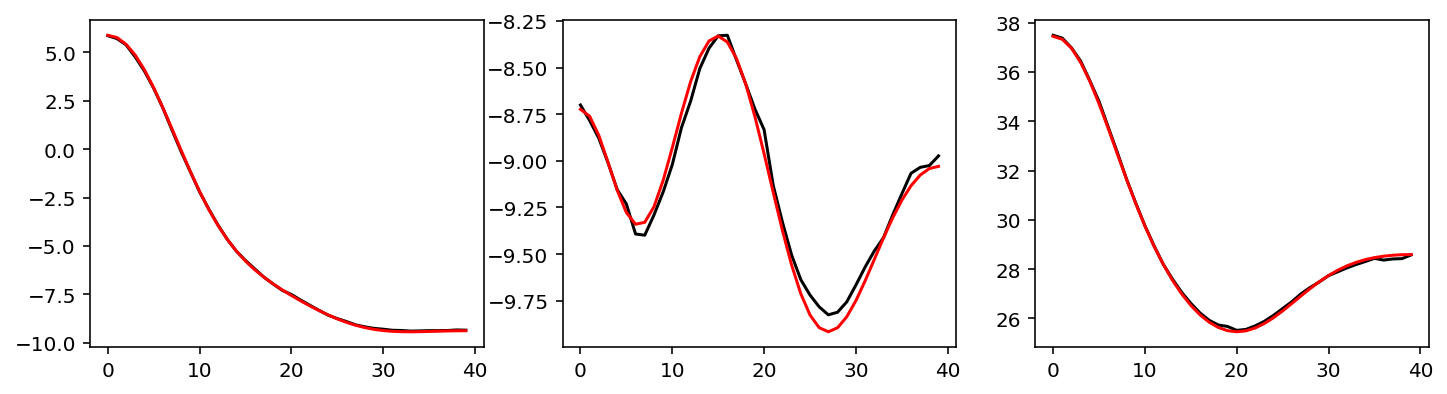

In [23]:
sample = 25
prediction = model0(feature0_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_train[sample][k], color="red");

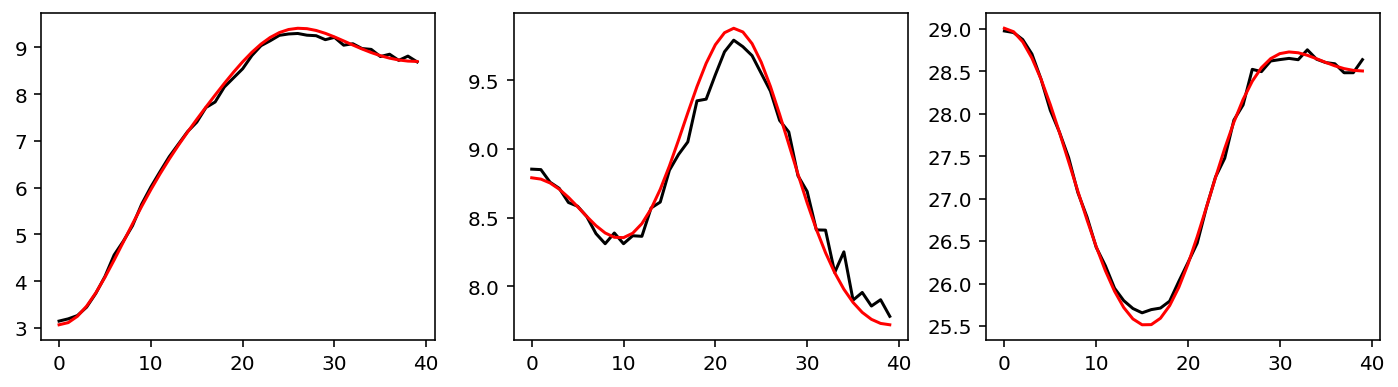

In [24]:
sample = 25
prediction = model0(feature0_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_test[sample][k], color="red");

### With truncation

In [25]:
key = random.PRNGKey(23)

N_features = [feature0_train.shape[1], 64, targets0_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
model0 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [26]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature0_train.shape[0] / N_batch) * N_epoch_decay, 0.75)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model0, eqx.is_array))

In [27]:
ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

In [28]:
%timeit ChebNO.make_step(model0, feature0_train[:N_batch], targets0_train[:N_batch], optim, opt_state);

12.9 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
22 * 1e-3 * (feature0_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [30]:
%timeit ChebNO.compute_loss(model0, feature0_train, targets0_train);

127 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature0_train, targets0_train], key, N_batch)
    for feature, target in ds:
        loss, model0, opt_state = ChebNO.make_step(model0, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model0, feature0_train, targets0_train).item())
    e_test.append(ChebNO.compute_loss(model0, feature0_test, targets0_test).item())

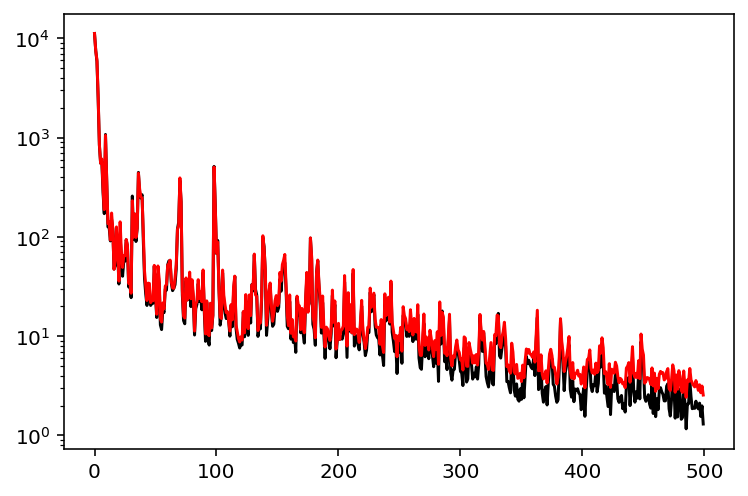

In [32]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

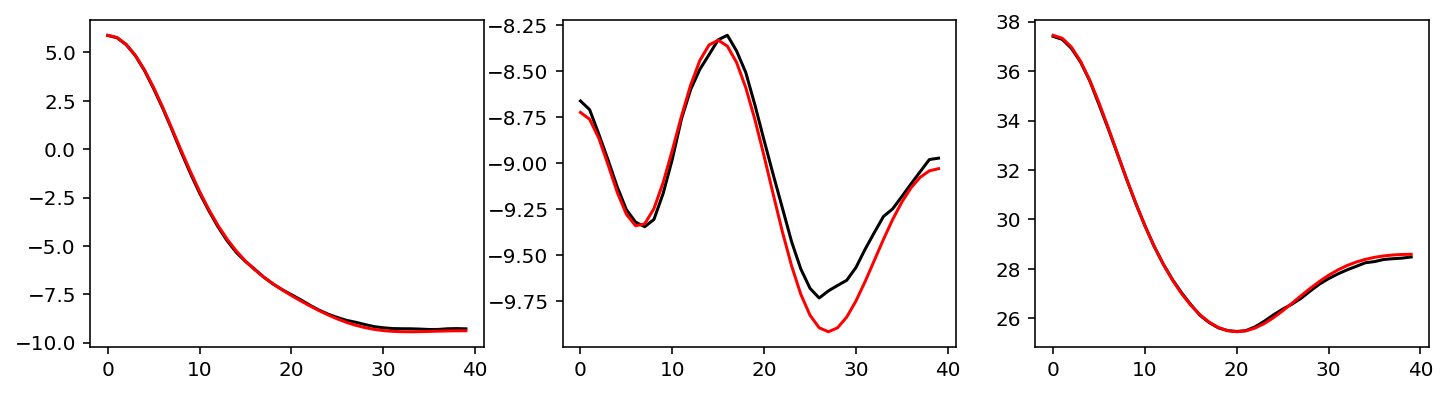

In [33]:
sample = 25
prediction = model0(feature0_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_train[sample][k], color="red");

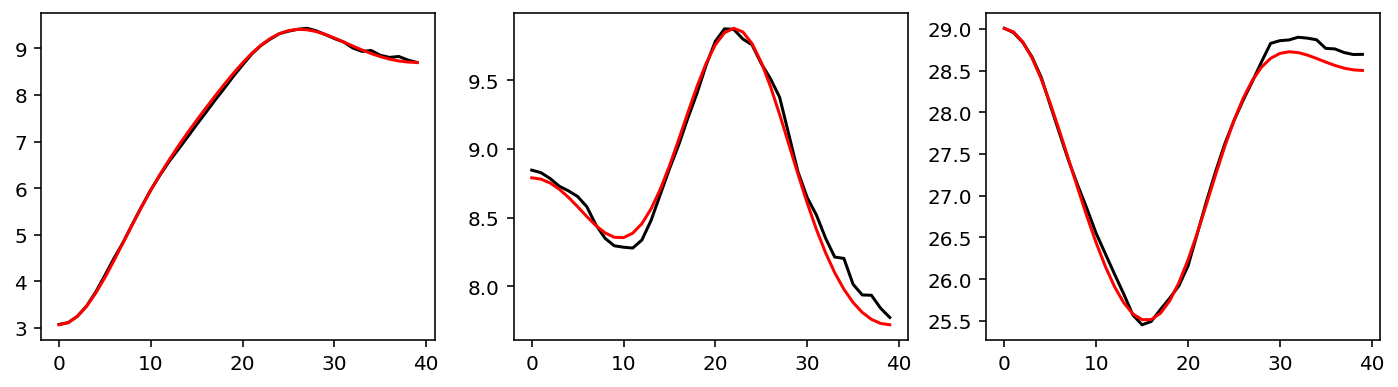

In [34]:
sample = 25
prediction = model0(feature0_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(feature0_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets0_test[sample][k], color="red");

## Reach features

### Without truncation

In [35]:
key = random.PRNGKey(23)

N_features = [feature2_train.shape[1], 64, targets2_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = feature0_train.shape[2]
model2 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [36]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature2_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model2, eqx.is_array))

In [37]:
ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

In [38]:
%timeit ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

21.5 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
22 * 1e-3 * (feature2_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [40]:
%timeit ChebNO.compute_loss(model2, feature2_train, targets2_train);

217 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature2_train, targets2_train], key, N_batch)
    for feature, target in ds:
        loss, model2, opt_state = ChebNO.make_step(model2, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model2, feature2_train, targets2_train).item())
    e_test.append(ChebNO.compute_loss(model2, feature2_test, targets2_test).item())

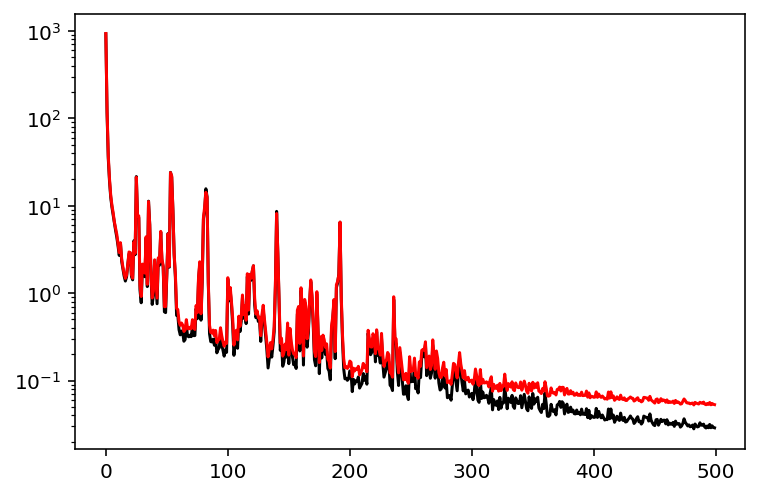

In [42]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

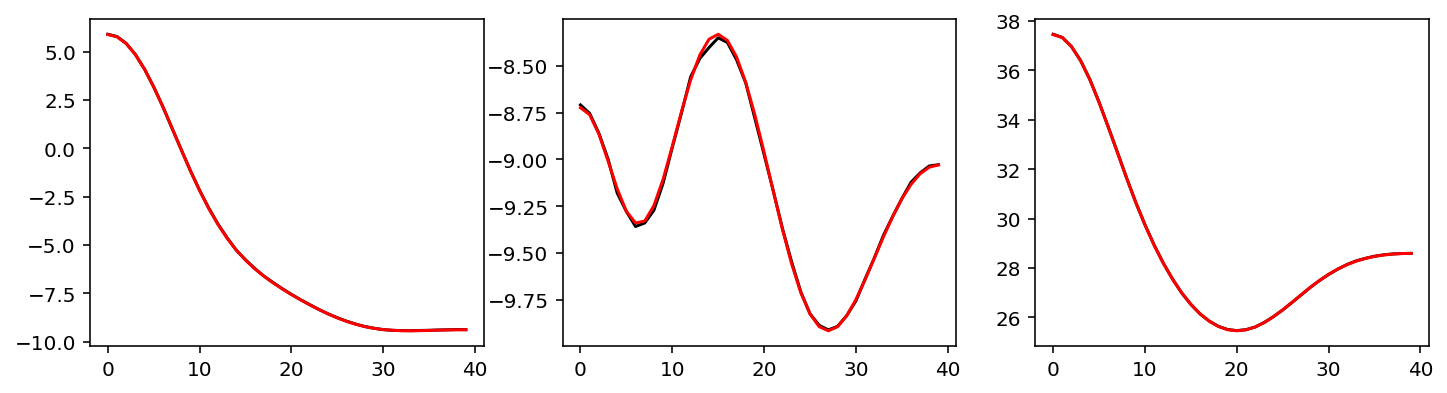

In [43]:
sample = 25
prediction = model2(feature2_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_train[sample][k], color="red");

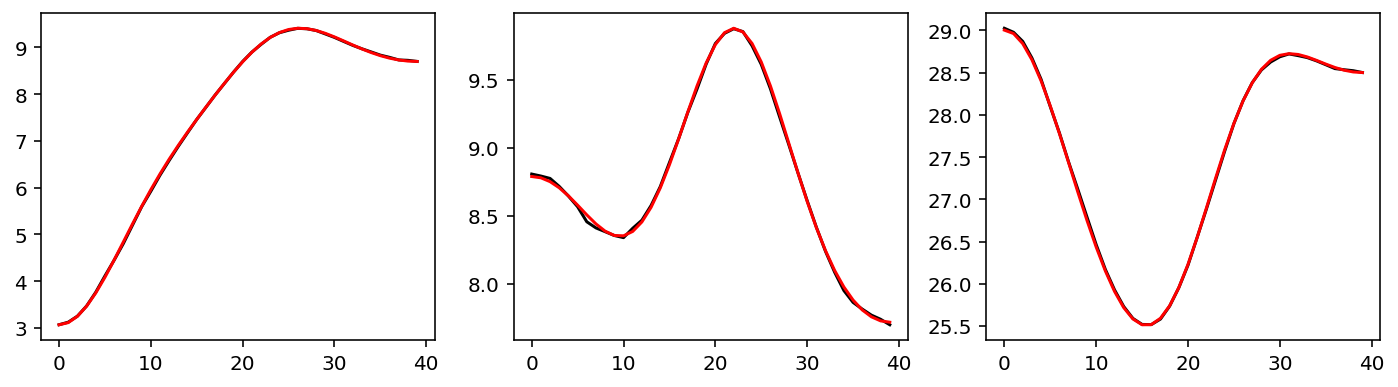

In [44]:
sample = 25
prediction = model2(feature2_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_test[sample][k], color="red");

### With truncation

In [45]:
key = random.PRNGKey(23)

N_features = [feature2_train.shape[1], 64, targets2_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
model2 = ChebNO.ChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key)

In [46]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 40
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature2_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model2, eqx.is_array))

In [47]:
ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

In [48]:
%timeit ChebNO.make_step(model2, feature2_train[:N_batch], targets2_train[:N_batch], optim, opt_state);

12.6 ms ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
22 * 1e-3 * (feature2_train.shape[0] / N_batch) * N_epoch / 60

7.333333333333332

In [50]:
%timeit ChebNO.compute_loss(model2, feature2_train, targets2_train);

130 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature2_train, targets2_train], key, N_batch)
    for feature, target in ds:
        loss, model2, opt_state = ChebNO.make_step(model2, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model2, feature2_train, targets2_train).item())
    e_test.append(ChebNO.compute_loss(model2, feature2_test, targets2_test).item())

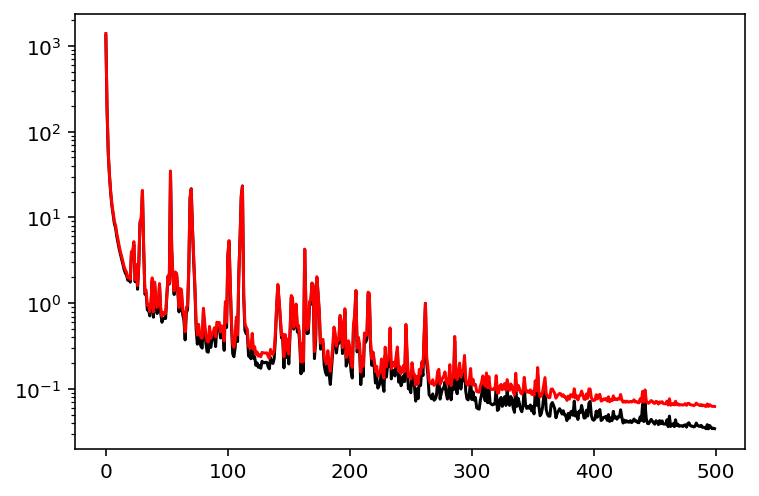

In [52]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

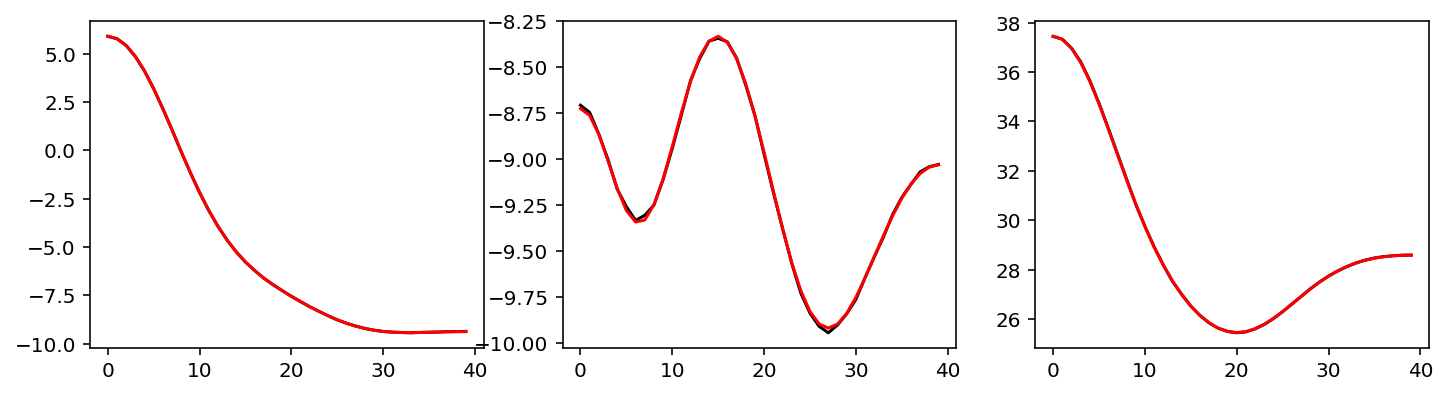

In [53]:
sample = 25
prediction = model2(feature2_train[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_train[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_train[sample][k], color="red");

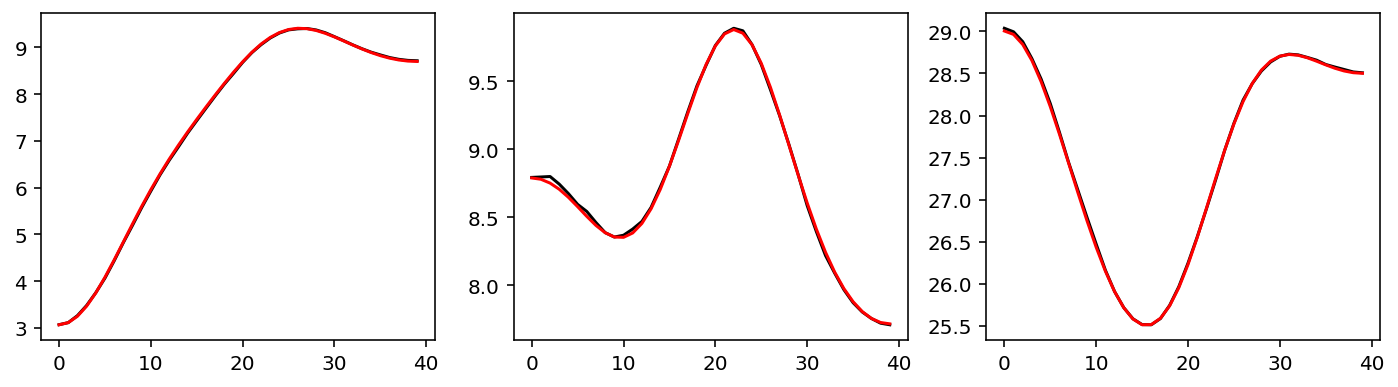

In [54]:
sample = 25
prediction = model2(feature2_test[sample])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for k in range(targets2_test[sample].shape[0]):
    ax[k].plot(prediction[k], color="black")
    ax[k].plot(targets2_test[sample][k], color="red");